In [80]:
import gzip
import json
from os import PathLike
from typing import List, Tuple, TypeAlias
from huggingface_hub import list_datasets
from datasets import load_dataset, load_dataset_builder
from itertools import islice
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from functools import wraps


def load_jsonl(path, open=open) -> List[dict]:
    data = []
    with open(path, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data


def levenshtein_distance(s1: List[int], s2: List[int]) -> int:
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for index2, char2 in enumerate(s2):
        new_distances = [index2 + 1]
        for index1, char1 in enumerate(s1):
            if char1 == char2:
                new_distances.append(distances[index1])
            else:
                new_distances.append(
                    1
                    + min((distances[index1], distances[index1 + 1], new_distances[-1]))
                )
        distances = new_distances

    return distances[-1]


def truncate(sample: str) -> str:
    return (
        sample.strip().split("\n\n\n")[0]
        if "\n\n\n" in sample
        else sample.strip().split("```")[0]
    )


def tokenize_code(sample: str, tokenizer: PreTrainedTokenizerBase, length: int) -> List[int]:
    return tokenizer.encode(sample)[:length] if length else tokenizer.encode(sample)


def get_edit_distance_distribution_star(
    samples: List[List[int]],
    gready_sample: List[int],
):
    num = []
    max_length = len(gready_sample)
    for sample in samples:
        num.append(levenshtein_distance(gready_sample, sample))
        max_length = max(max_length, len(sample))
    return num, max_length


def calculate_ratio(numbers: List[int], threshold: float) -> float:
    count = sum(1 for num in numbers if num <= threshold)
    total = len(numbers)
    ratio = count / total if total > 0 else 0
    return ratio

# Spefcific implementations

def gpto_get_samples(item: dict):
    def unwrap(sample: str):
        unwrapped = sample.strip("```java\n").strip("```").strip()
        truncated = truncate(unwrapped)
        return truncated
    
    if not item["generation"]:
        return None
    samples = (c["message"]["content"] for c in item["generation"]["choices"])
    cleaned_samples = map(unwrap, samples)
    # replace "\n" with line break
    return list(cleaned_samples)

def gpto_get_samples_greedy(item: dict):
    samples = gpto_get_samples(item)
    return samples[0] if samples else None

In [72]:
Tokens: TypeAlias = List[int]

alpha: float = 0.05
xi: float = 0.01
max_length: int = 100
tokenizer_str: str = "codellama/CodeLlama-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_str)

conf_list = [
    {
        "identifier": "Defect4J gpt-4o",
        "greedy_path": "data/gpt-4o/defects4j/greedy/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
        "multiple_path": "data/gpt-4o/defects4j/multiple/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
        "method": "gpt-4o",
    },
    {
        "identifier": "GitBugJava gpt-4o",
        "greedy_path": "data/gpt-4o/gitbug-java/greedy/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
        "multiple_path": "data/gpt-4o/gitbug-java/multiple/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
        "method": "gpt-4o",
    },
]

skipped_list = []
peaks_list = []
dists_list = []
for conf in conf_list:
    run_identifier = conf["identifier"]
    greedy_path = conf["greedy_path"]
    multiple_path = conf["multiple_path"]
    # Load the multiple generation data
    if multiple_path.endswith(".gz"):
        data = load_jsonl(multiple_path, gzip.open)
    else:
        data = load_jsonl(multiple_path)
    multiple_samples_taskset = data

    # Load the greedy generation data
    if greedy_path.endswith(".gz"):
        data = load_jsonl(greedy_path, gzip.open)
    else:
        data = load_jsonl(greedy_path)
    greedy_samples_taskset = data
    
    # dataset speficic functions
    match conf["method"]:
        case "gpt-4o":
            greedy_sample_fun = gpto_get_samples_greedy
            samples_fun = gpto_get_samples
        case _:
            raise ValueError(f"Unknown method: {conf['method']}")
    
    # get greedy samples
    greedy_samples_taskset_map = {sample["identifier"]: greedy_sample_fun(sample) for sample in greedy_samples_taskset}
    
    n_samples = len(multiple_samples_taskset)
    Skipped = [False for _ in range(n_samples)]
    Dists = [None for _ in range(n_samples)]
    Peaks = [None for _ in range(n_samples)]
    for i, task in enumerate(multiple_samples_taskset):
        task_identifier = task["identifier"]
        # Tokenize the samples
        samples = samples_fun(task)
        if not samples:
            Skipped[i] = True
            continue
        samples: List[Tokens] = [
            tokenize_code(s, tokenizer, max_length) for s in samples
        ]
        # Tokenize the greedy sample
        if task_identifier not in greedy_samples_taskset_map:
            Skipped[i] = True
            continue
        gready_sample_str = greedy_samples_taskset_map[task_identifier]
        gready_sample: Tokens = tokenize_code(gready_sample_str, tokenizer, max_length)
        # Calculate the edit distance distribution
        dist, ml = get_edit_distance_distribution_star(samples, gready_sample)
        Dists[i] = dist
        peak = calculate_ratio(dist, alpha * ml)
        Peaks[i] = peak

    # Add results to the lists
    skipped_list.append(Skipped)
    dists_list.append(Dists)
    peaks_list.append(Peaks)


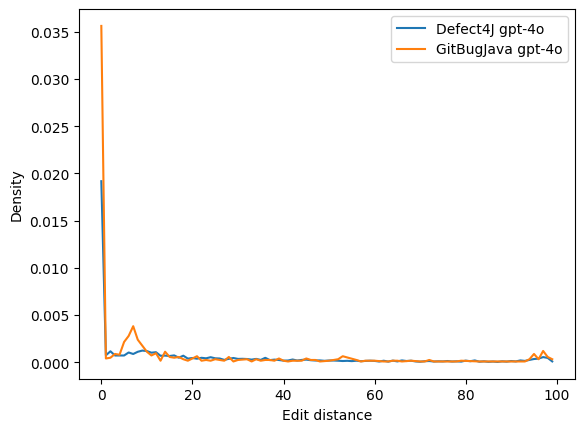

In [79]:
# We have a list of identifiers and a list of edit distances
# We want a line plot of multiple lines
# - x-axis is the edit distance
# - y-axis is the ratio of samples that have an equal edit-distance
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple

identifiers = [e["identifier"] for e in conf_list]
for i, dists in enumerate(dists_list):
    d_full = filter(None, dists)  # Remove None values
    d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
    d_full = list(d_full)
    total = sum(d_full)
    count = Counter(d_full)
    x, y = zip(*sorted(count.items(), key=lambda x: x[0]))
    y = [c / total for c in y]
    plt.plot(x, y, label=identifiers[i])
plt.xlabel("Edit distance")
plt.ylabel("Density")
plt.legend()

plt.show()